# Predictive Modeling

"A Two Stage Model for Predicting Winners in MLB" Yang and Swartz

In [1]:
import math
from math import e

import statistics

import pymc3 as pm

import numpy as np
from numpy import random

import pandas as pd
import pymc3 as pm

import scipy as sc
from scipy.stats import uniform, bernoulli, beta, expon, gamma, mannwhitneyu

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (7,5)

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

## Getting the Data

In order to be able to run the model, we'll need 3 statistics:
1. Earned Run Average (ERA), for home and away.
2. Winning percent ratio
3. Team batting average

All stats except the ERA stats were downloaded from baseball-reference.com. The ERA, split for Home and Away, was gathered from fangraphs.

### Earned Running Average

In [2]:
pitching_2014h = pd.read_csv('2014_ERA_Home.csv') # Reading the necessary files
pitching_2014a = pd.read_csv('2014_ERA_Away.csv')

pitching_2015h = pd.read_csv('2015_ERA_Home.csv')
pitching_2015a = pd.read_csv('2015_ERA_Away.csv')

pitching_2016h = pd.read_csv('2016_ERA_Home.csv')
pitching_2016a = pd.read_csv('2016_ERA_Away.csv')

pitching_2017h= pd.read_csv('2017_ERA_Home.csv')
pitching_2017a = pd.read_csv('2017_ERA_Away.csv')

In [3]:
ERA_2014 = pd.DataFrame() # Creating a df for each year
ERA_2015 = pd.DataFrame()
ERA_2016 = pd.DataFrame()
ERA_2017 = pd.DataFrame()

ERA_2014['Team'] = pitching_2014h['Team'] # Getting appropriate data
ERA_2014['ERA_Home'] = pitching_2014h['ERA']
ERA_2014['ERA_Away'] = pitching_2014a['ERA']

ERA_2015['Team'] = pitching_2015h['Team']
ERA_2015['ERA_Home'] = pitching_2015h['ERA']
ERA_2015['ERA_Away'] = pitching_2015a['ERA']

ERA_2016['Team'] = pitching_2016h['Team']
ERA_2016['ERA_Home'] = pitching_2016h['ERA']
ERA_2016['ERA_Away'] = pitching_2016a['ERA']

ERA_2017['Team'] = pitching_2017h['Team']
ERA_2017['ERA_Home'] = pitching_2017h['ERA']
ERA_2017['ERA_Away'] = pitching_2017a['ERA']

In [4]:
# Replacing Team name with their abbreviations as the team names are not compatible with the other resources
era_list = [ERA_2014, ERA_2015, ERA_2016, ERA_2017]
team_names = ['Angels', 'Astros', 'Athletics', 'Blue Jays', 'Braves', 'Brewers', 'Cardinals', 'Cubs', 'Diamondbacks', 'Dodgers', 'Giants', 'Indians', 'Mariners', 'Marlins', 'Mets', 'Nationals', 'Orioles', 'Padres', 'Phillies', 'Pirates', 'Rangers', 'Rays', 'Red Sox', 'Reds', 'Rockies', 'Royals', 'Tigers', 'Twins', 'White Sox', 'Yankees']
team_abvr = ['LAA', 'HOU', 'OAK', 'TOR', 'ATL', 'MIL', 'STL', 'CHC', 'ARI', 'LAD', 'SFG', 'CLE', 'SEA', 'MIA', 'NYM', 'WSN', 'BAL', 'SDP', 'PHI', 'PIT', 'TEX', 'TBR', 'BOS', 'CIN', 'COL', 'KCR', 'DET', 'MIN', 'CHW', 'NYY']

for dataframe in era_list:
    dataframe.replace(team_names, team_abvr, inplace=True)

In [5]:
for df in era_list: # Sorting alphabetically
    df.sort_values('Team', inplace=True)
ERA_2014 = ERA_2014.reset_index(drop=True) # Resetting index
ERA_2015 = ERA_2015.reset_index(drop=True)
ERA_2016 = ERA_2016.reset_index(drop=True)
ERA_2017 = ERA_2017.reset_index(drop=True)

In [6]:
ERA_2017.head() # ERA dataa

,Team,ERA_Home,ERA_Away
0,ARI,3.79,3.55
1,ATL,4.82,4.62
2,BAL,4.60,5.38
3,BOS,3.70,3.77
4,CHC,4.12,3.78


### Win Percent Ratio

In [7]:
standings_2014 = pd.read_csv('2014_standings.csv') # Reading from file
standings_2015 = pd.read_csv('2015_standings.csv')
standings_2016 = pd.read_csv('2016_standings.csv')
standings_2017 = pd.read_csv('2017_standings.csv')

In [8]:
wl_2014 = standings_2014[['Tm', 'W-L%']] # Getting data
wl_2015 = standings_2015[['Tm', 'W-L%']]
wl_2016 = standings_2016[['Tm', 'W-L%']]
wl_2017 = standings_2017[['Tm', 'W-L%']]

wl_2014.sort_values('Tm', inplace=True) # Sorting by team
wl_2015.sort_values('Tm', inplace=True)
wl_2016.sort_values('Tm', inplace=True)
wl_2017.sort_values('Tm', inplace=True)


wl_2014 = wl_2014.reset_index(drop=True) # Resetting by index
wl_2015 = wl_2015.reset_index(drop=True)
wl_2016 = wl_2016.reset_index(drop=True)
wl_2017 = wl_2017.reset_index(drop=True)

wl_2014.head()

,Tm,W-L%
0,ARI,0.395
1,ATL,0.488
2,Avg,0.500
3,BAL,0.593
4,BOS,0.438


### Batting Average

In [9]:
batting_2014 = pd.read_csv('2014_batting.csv') # Reading
batting_2015 = pd.read_csv('2015_batting.csv')
batting_2016 = pd.read_csv('2016_batting.csv')
batting_2017 = pd.read_csv('2017_batting.csv')

In [10]:
batting_average_2014 = batting_2014[['Tm', 'BA']] # Getting data
batting_average_2015 = batting_2015[['Tm', 'BA']]
batting_average_2016 = batting_2016[['Tm', 'BA']]
batting_average_2017 = batting_2017[['Tm', 'BA']]

batting_average_2014.head()

,Tm,BA
0,ARI,0.248
1,ATL,0.241
2,BAL,0.256
3,BOS,0.244
4,CHC,0.239


### Combined

In [11]:
data_2014 = pd.DataFrame() # Final df with all data combined into one
data_2015 = pd.DataFrame()
data_2016 = pd.DataFrame()
data_2017 = pd.DataFrame()

data_2014[['Team', 'ERA_Home', 'ERA_Away']] = ERA_2014[['Team', 'ERA_Home', 'ERA_Away']] # Passing each df into columns.
data_2014['W/L%'] = wl_2014['W-L%']
data_2014['BA'] = batting_average_2014['BA']

data_2015[['Team', 'ERA_Home', 'ERA_Away']] = ERA_2015[['Team', 'ERA_Home', 'ERA_Away']]
data_2015['W/L%'] = wl_2015['W-L%']
data_2015['BA'] = batting_average_2015['BA']

data_2016[['Team', 'ERA_Home', 'ERA_Away']] = ERA_2016[['Team', 'ERA_Home', 'ERA_Away']]
data_2016['W/L%'] = wl_2016['W-L%']
data_2016['BA'] = batting_average_2016['BA']

data_2017[['Team', 'ERA_Home', 'ERA_Away']] = ERA_2017[['Team', 'ERA_Home', 'ERA_Away']]
data_2017['W/L%'] = wl_2017['W-L%']
data_2017['BA'] = batting_average_2017['BA']

data_2014.head()

,Team,ERA_Home,ERA_Away,W/L%,BA
0,ARI,4.31,4.20,0.395,0.248
1,ATL,3.13,3.65,0.488,0.241
2,BAL,3.22,3.66,0.500,0.256
3,BOS,4.06,3.96,0.593,0.244
4,CHC,3.47,4.41,0.438,0.239


In [12]:
print(data_2016.loc[10]) # Looking at 2016 - 2017 Statistics
print(data_2017.loc[10])

Team          HOU
ERA_Home      3.4
ERA_Away     4.79
W/L%        0.534
BA          0.247
Name: 10, dtype: object
Team          HOU
ERA_Home     3.65
ERA_Away     4.61
W/L%        0.395
BA          0.282
Name: 10, dtype: object


### Games

In [13]:
from pybaseball import schedule_and_record # Getting schedule 

HOU_2014_ = schedule_and_record(2014, "HOU")
HOU_2015_ = schedule_and_record(2015, "HOU")
HOU_2016_ = schedule_and_record(2016, "HOU")
HOU_2017_ = schedule_and_record(2017, "HOU")

In [14]:
HOU_2014 = HOU_2014_ # Necessary as to not have to get data everytime. Getting data takes a while
HOU_2015 = HOU_2015_
HOU_2016 = HOU_2016_
HOU_2017 = HOU_2017_

In [15]:
schedules = [HOU_2014, HOU_2015, HOU_2016, HOU_2017]

HOU_2014 = HOU_2014[['Home_Away', 'Opp', 'W/L']] # Only getting necessary columns. Rest is discarded
HOU_2015 = HOU_2015[['Home_Away', 'Opp', 'W/L']]
HOU_2016 = HOU_2016[['Home_Away', 'Opp', 'W/L']]
HOU_2017 = HOU_2017[['Home_Away', 'Opp', 'W/L']]

HOU_2014.loc[HOU_2014['Home_Away'] == 'Home', 'is_home'] = 1 # Bool if home/away. 
HOU_2014.loc[HOU_2014['Home_Away'] != 'Home', 'is_home'] = 0

HOU_2015.loc[HOU_2015['Home_Away'] == 'Home', 'is_home'] = 1
HOU_2015.loc[HOU_2015['Home_Away'] != 'Home', 'is_home'] = 0

HOU_2016.loc[HOU_2016['Home_Away'] == 'Home', 'is_home'] = 1
HOU_2016.loc[HOU_2016['Home_Away'] != 'Home', 'is_home'] = 0

HOU_2017.loc[HOU_2017['Home_Away'] == 'Home', 'is_home'] = 1
HOU_2017.loc[HOU_2017['Home_Away'] != 'Home', 'is_home'] = 0

# .loc does not work based off of tm_abv. Using idx instead.
idx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
tm_abv = ["ARI", "ATL", "BAL", "BOS", "CHC", "CHW", "CIN", "CLE", "COL", "DET", "HOU", "KCR", "LAA", "LAD", "MIA", "MIL", "MIN", "NYM", "NYY", "OAK", "PHI", "PIT", "SDP", "SEA", "SFG", "STL", "TBR", "TEX", "TOR", "WSN"]
  
HOU_2014['Opp'].replace(tm_abv, idx, inplace=True) # Replacing team_abv with idx.
HOU_2015['Opp'].replace(tm_abv, idx, inplace=True)
HOU_2016['Opp'].replace(tm_abv, idx, inplace=True)
HOU_2017['Opp'].replace(tm_abv, idx, inplace=True)

In [16]:
HOU_2015.head()

,Home_Away,Opp,W/L,is_home
1,Home,7,W,1.0
2,Home,7,L,1.0
3,Home,7,L,1.0
4,@,27,W,0.0
5,@,27,L,0.0


# The Model

## Initializing Hyperparameters

In [17]:
def Initialize_Variables(data,
                         team,
                         game_opponents,
                         is_home,
                         a_i = 2,
                         delta_zero = 0,
                         delta_one = 2,
                         m_0 = 10):
    """Initializes variables in the model in order to calculate the values using Gibbs
    
    
    """
        
    winning_ratio_opposition = data[['W/L%']]
    batting_average_opposition = data[['BA']]
    era_home_opposition = data[['ERA_Home']]
    era_away_opposition = data[['ERA_Away']]
    
    winning_ratio_team = data.loc[team].values[3]
    batting_average_team = data.loc[team].values[4]
    era_home = data.loc[team].values[1]
    era_away = data.loc[team].values[2] 
    
    alpha_s = [] # Ratio of home vs. away winning percentages
    beta_s = [] # Ratio of home vs. away batting averages
    gamma_s = [] # Ratio of away vs home ERAs
    lambda_s = [] # Relative team strength, in the perspective of team
    
    i = 0
    
    for team in game_opponents:
        r_1 = np.random.uniform(0, a_i)
        r_2 = np.random.uniform(0, a_i)
        r_3 = np.random.uniform(0, a_i)
        
        winning_ratio_opp = winning_ratio_opposition.loc[team].values[0]
        batting_average_opp = batting_average_opposition.loc[team].values[0]
        era_home_opp = era_home_opposition.loc[team].values[0]
        era_away_opp = era_away_opposition.loc[team].values[0]
        
        if (is_home[i] == 1):
            alpha_s.append(winning_ratio_team/winning_ratio_opp) 
            beta_s.append(batting_average_team/batting_average_opp)
            gamma_s.append(era_away_opp/era_home)
            lambda_s.append(alpha_s[i]**r_1 * beta_s[i]**r_2 * gamma_s[i]**r_3)
            
        else:
            alpha_s.append(winning_ratio_opp/winning_ratio_team)
            beta_s.append(batting_average_opp/batting_average_team)
            gamma_s.append(era_home/era_home_opp)
            lambda_s.append((1/alpha_s[i])**r_1 * (1/beta_s[i])**r_2 * (1/gamma_s[i])**r_3)
        i += 1
        
    return lambda_s

### A Look at Relative Advantage (λ)

$$ \lambda_s = \alpha_s^{r_1} * \beta_s^{r_2} * \gamma_s^{r_3} $$ 
Where $\alpha$ denotes the winning percentages ratio between the home and away team, $\beta$ denotes the ratio between the batting averages, $\gamma$ denotes the ratio of the ERA, in this instance the ratio between away and home.

$1/\lambda_s$ is relative advantage for away games.

As the function calculates the relative advantage a team has throughout their season, lets look at the Astros' relative advantage over their opponents. When $λ > 1$, that means that the team has an advantage. When $λ < 1$, the team has a disadvantage.

In [18]:
# Plotting Astros Advantage for 162 Games, for 4 years
# is_home_2014 = HOU_2014['is_home'].values
# is_home_2015 = HOU_2015['is_home'].values
is_home_2016 = HOU_2016['is_home'].values
is_home_2017 = HOU_2017['is_home'].values

# lambda_s_2014 = Initialize_Variables(data = data_2014, team = 10, game_opponents = HOU_2014['Opp'], is_home = is_home_2014)
# lambda_s_2015 = Initialize_Variables(data = data_2015, team = 10, game_opponents = HOU_2015['Opp'], is_home = is_home_2015)
lambda_s_2016 = Initialize_Variables(data = data_2016, team = 10, game_opponents = HOU_2016['Opp'], is_home = is_home_2016)
lambda_s_2017 = Initialize_Variables(data = data_2017, team = 10, game_opponents = HOU_2017['Opp'], is_home = is_home_2017)

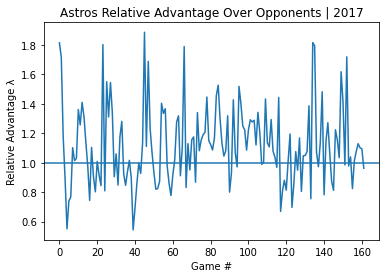

Lambda mean: 1.1177771148647004


In [19]:
plt.plot(lambda_s_2017)
plt.axhline(1)

plt.xlabel("Game #")
plt.ylabel("Relative Advantage λ")

plt.title("Astros Relative Advantage Over Opponents | 2017")
plt.show()

print("Lambda mean:", statistics.mean(lambda_s_2017))

As we can see, the relative advantage varies significantly. This can be attributed to the home vs. away game differences has on ERA, which is causing this volatility. The Astros in 2017, not looking at cheating, were a good team. On average, their advantage > 1, meaning that they, on average, held an advantage, regardless of whether the game took place at home or away.

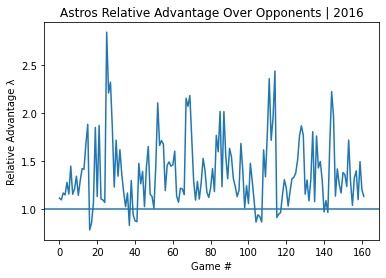

Lambda mean: 1.37768015899531


In [20]:
plt.plot(lambda_s_2016)
plt.axhline(1)

plt.xlabel("Game #")
plt.ylabel("Relative Advantage λ")

plt.title("Astros Relative Advantage Over Opponents | 2016")
plt.show()

print("Lambda mean:", statistics.mean(lambda_s_2016))

2016 looks entierly different than 2017. While there still remains the volatility, The beginning of the season looks weaker when compared to 2017. Even through mean for 2016 is greater than the mean for 2017 (1.16 > 1.329), the Win-loss percentage is lower than it was in 2017, about a 10% difference (0.519 to 0.623).

Let's try another team. The Boston Red Sox

In [21]:
# Getting appropriate stats and cleaning
BOS_2017 = schedule_and_record(2017, "BOS")

BOS_2017 = BOS_2017[['Home_Away', 'Opp', 'W/L']] # Getting only necessary columns.

BOS_2017.loc[BOS_2017['Home_Away'] == 'Home', 'is_home'] = 1 # Bool as to whether the team plays home or away
BOS_2017.loc[BOS_2017['Home_Away'] != 'Home', 'is_home'] = 0
is_home_BOS_2017 = BOS_2017['is_home'].values

BOS_2017['Opp'].replace(tm_abv, idx, inplace=True) # Replacing team abreveations as numbers

lambda_s_BOS_2017 = Initialize_Variables(data = data_2017, team = 3, game_opponents = BOS_2017['Opp'], is_home = is_home_BOS_2017)

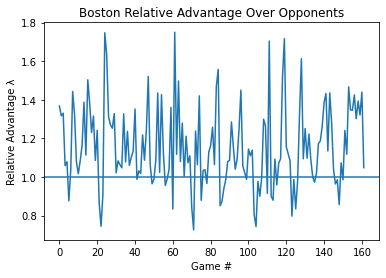

Lambda mean: 1.1547892335466334


In [22]:
plt.plot(lambda_s_BOS_2017)
plt.axhline(1)

plt.xlabel("Game #")
plt.ylabel("Relative Advantage λ")

plt.title("Boston Relative Advantage Over Opponents")
plt.show()

print("Lambda mean:", statistics.mean(lambda_s_BOS_2017))

The Red Sox usually has an advantage over other teams. This makes sense when in context of their performance as they are high performers, and have one the World Series twice in the past couple of years, 2018 and 2013.

The Detroit Tigers where had one of the lowest Win/Loss Percentages. Let's look at their advantage.

In [23]:
DET_2017 = schedule_and_record(2017, "DET")

DET_2017 = DET_2017[['Home_Away', 'Opp', 'W/L']] # Getting only necessary columns.

DET_2017.loc[BOS_2017['Home_Away'] == 'Home', 'is_home'] = 1 # Bool as to whether the team plays home or away
DET_2017.loc[BOS_2017['Home_Away'] != 'Home', 'is_home'] = 0
is_home_DET_2017 = BOS_2017['is_home'].values

DET_2017['Opp'].replace(tm_abv, idx, inplace=True) # Replacing team abreveations as numbers

lambda_s_DET_2017 = Initialize_Variables(data = data_2017, team = 9, game_opponents = DET_2017['Opp'], is_home = is_home_DET_2017)

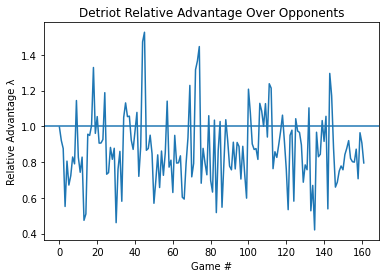

Lambda mean: 0.874194129065386


In [24]:
plt.plot(lambda_s_DET_2017)
plt.axhline(1)

plt.xlabel("Game #")
plt.ylabel("Relative Advantage λ")

plt.title("Detriot Relative Advantage Over Opponents")
plt.show()

print("Lambda mean:", statistics.mean(lambda_s_DET_2017))

The Relative Advantage below 1 makes sense in this context. Detroit is a poor performing team, and that is reflected in that they consistantly, barring a few instances, are the weaker team.

### Astros λ Predicted

While relative advantage is not the focus of the model, we find that it is an interesting opportunity to ask the question as to whether the Sign-Stealing-Scandal helped them improve their advantage. We propose a hypothesis test where the null-hypothesis $H_0$ is that difference between the 2017 predicted advantages and the 2017 actual advantages is not significant such that $p > 0.01$. The alternative hypothesis $H_1$ is that difference is significant and that $p < 0.01$.

In [25]:
pred = [3.247, 4.87, 0.4947, 0.2513] # Astros 2017 predicted values with simple linear regression
act = [3.65, 4.61, 0.395, 0.282]
data_2017.loc[10].replace(act, pred)

lambda_s_2017_pred = Initialize_Variables(data = data_2017, team = 10, game_opponents = HOU_2017['Opp'], is_home = is_home_2017)


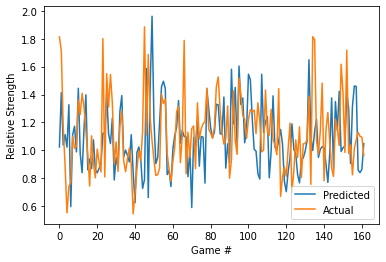

Lambda mean predicted: 1.088295937724517
Lambda mean actual: 1.1177771148647004


In [26]:
plt.plot(lambda_s_2017_pred, label= "Predicted")
plt.plot(lambda_s_2017, label = "Actual")
plt.xlabel("Game #")
plt.ylabel("Relative Strength")
plt.legend()
plt.show()

print("Lambda mean predicted:", statistics.mean(lambda_s_2017_pred))
print("Lambda mean actual:", statistics.mean(lambda_s_2017))

In [27]:
# Mann-Whitney Test
p = sc.stats.mannwhitneyu(lambda_s_2017, lambda_s_2017_pred)
print("Mann-Whitney P-Score:", p[1])

Mann-Whitney P-Score: 0.19279096575828142


As $p > 0.01$, $p = 0.30314$, we are unable to reject the null-hypothesis. Even more so, the predicted is higher than the actual, meaning that the predicted values performed higher than when the Astros cheated. This can be attributed to the rather rudimentary linear regression with very high R-Squared values. 

## Predictive Modeling

$$p_s \sim beta(m\lambda\delta,m)$$
$$X_t \sim Bernoulli(p_s)$$

In [28]:
def predict(lambda_s, m, delta):
    p_t = []
    for lambda_t in lambda_s:
        alpha = lambda_t * m * delta
        p_t.append(sc.stats.beta.mean(alpha, m))
    X_t = []
    for p_s in p_t:
        X_t.append(sc.stats.bernoulli.mean(p_s))
    return X_t

### Predicting Winners

In [29]:
delta = sc.stats.uniform.mean(0, 2)
m = sc.stats.expon.mean(10)
pred_act = predict(lambda_s = lambda_s_2017, m = m, delta = delta)

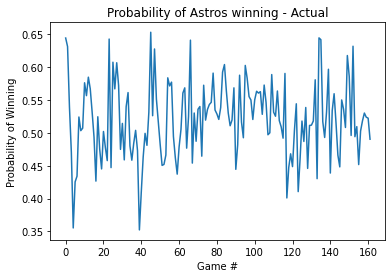

Mean probability 0.520717628101506


In [30]:
plt.plot(pred_act)
plt.xlabel("Game #")
plt.ylabel("Probability of Winning")

plt.title("Probability of Astros winning - Actual")
plt.show()

print("Mean probability", statistics.mean(pred_act))

The graph shows the probability that the Astros win game X, actual values. There is volatility in the data, but that is expected and makes sense as $\lambda_s$, calculated with home and away statistics in mind, also has high volatility. 

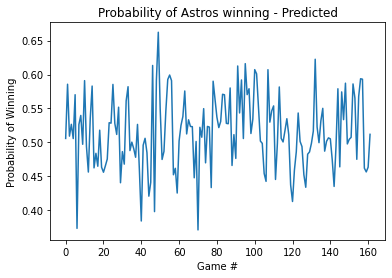

Mean probability 0.5151211027438019


In [31]:
delta = sc.stats.uniform.mean(0, 2)
m = sc.stats.expon.mean(10)
pred_pred = predict(lambda_s = lambda_s_2017_pred, m = m, delta = delta)
plt.plot(pred_pred)
plt.xlabel("Game #")
plt.ylabel("Probability of Winning")

plt.title("Probability of Astros winning - Predicted")
plt.show()
print("Mean probability", statistics.mean(pred_pred))

Here is the probability that the Astros wins, with the predicted values. The mean for both the actual and predicted probabilities is very close.

### Mann-Whitney Test

We propose a hypothesis test such that $H_0$ is that there is no significant difference such that $p > 0.01$. $H_1$ is that there is a significant difference between the predicted and actual values such that $p < 0.01$.

In [32]:
# Mann-Whitney Test
p = sc.stats.mannwhitneyu(pred_pred, pred_act)
print("Mann-Whitney P-Score:", p[1])

Mann-Whitney P-Score: 0.19279096575828142


As p > 0.01, we are unable to reject the null-hypothesis

### Testing the Accuracy

In [33]:
HOU_2017['Pred_Wins'] = pred_act

HOU_2017.loc[HOU_2017['Pred_Wins'] > 0.50, 'Pred_Wins_Letter'] = 'W'
HOU_2017.loc[HOU_2017['Pred_Wins'] <= 0.50, 'Pred_Wins_Letter'] = 'L'

HOU_2017['Pred_Accur'] = np.where(HOU_2017['W/L'] == HOU_2017['Pred_Wins_Letter'], 1, 0)

print("Accuracy:", HOU_2017['Pred_Accur'].sum()/162)

Accuracy: 0.5802469135802469


# Key Takeaway

1. We are unable to reject the null hypothesis that better stats caused by sign-stealing improved their chances of winning.

# Room for Improvement

1. Get better predicted values using player modeling and gibbs sampling, rather than linear regression and uniform distributions.
2. Use a different model taking into account different statistics. This model weighs equally, overall, pitcher, and batter statistics, possibly diminishing the effect of advantages gained through sign-stealing.